Notebook for cleaning (real-world) graphs from unrelated roads and apartment areas.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
from imposm.parser import OSMParser
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pkl
# import seaborn as sbn
import math
from tqdm import *
import re
import json

In [21]:
amenities = "amenity::(fast_food|bar|bbq|biergarten|cafe|food_court|ice_cream|pub|restaurant)"

In [22]:
def get_hours(tags):
    m = re.search("opening_hours::[A-z- ]*(\d+):(\d+)-(\d+):(\d+)",tags)
    m2 = re.search(amenities,tags)
    if m and m2:
        return int(float(m.group(3)) + float(m.group(4))/60. - float(m.group(1)) - float(m.group(2))/60.)
    else:
        return -1

In [23]:
get_hours("amenity::cafe;;cuisine::burger;;fvst:navnelbnr::23879;;name::Café Stygge;;opening_hours::10:30-22:00; Su off;;phone::+45 98142214;;website::http://cafestygge.dk/;;")

11

In [140]:
G = nx.Graph()
node_lat = {}
node_lon = {}
node_tags = {}
graph_id = 0
# fname = '../data/copenhagen_center.ntw'
# fname = '../data/cph_center_bigger.ntw'
fname = '../data/cph_center_sq.ntw' #delta 55.666 12.5617
with open(fname,'r') as f:
    t = f.readline().split()
    graph_id = int(t[0])
    print(t[0])
    nodes = int(t[1])
    edges = int(t[2])
    for i in range(edges):
        info = f.readline().split()
        id1 = int(info[0])
        id2 = int(info[1])
        assert(id1 < nodes)
        assert(id2 < nodes)
        G.add_edge(id1, id2, weight=info[2], etype=info[3])
    for i in range(nodes):
        info = f.readline().split()
        node_lat[i] = info[0]
        node_lon[i] = info[1]
        if (len(info) > 2):
            node_tags[i] = get_hours(info[2])
        else:
            node_tags[i] = -1
        if i not in G:
            G.add_node(i)
nx.set_node_attributes(G, 'lat', node_lat)
nx.set_node_attributes(G, 'lon', node_lon)

1507120011410109777


In [141]:
# build tree for points and find NN for each shop with working hours
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy import spatial

#nodes of a graph
shop_points = []
shop_points_tags = []

i = 0
for node in G.nodes_iter():
    if node_tags[i] > -1:
        shop_points.append((float(G.node[node]['lat']), float(G.node[node]['lon'])))
        shop_points_tags.append(node_tags[i])
    i += 1

In [142]:
to_delete = []
for edge in nx.edges_iter(G):
    if G[edge[0]][edge[1]]["etype"] in ["unrelated",'cycleway','pedestrian','footway','steps','path','railway']:
        to_delete.append(edge)
for e in to_delete:
    G.remove_edge(e[0],e[1])
    
to_delete = []
for node in nx.nodes_iter(G):
    if G.degree(node) < 1:
        to_delete.append(node)
for n in to_delete:
    G.remove_node(n)

In [143]:
len(G)

31613

In [144]:
graphs = list(nx.connected_component_subgraphs(G))
print("total components", len(list(graphs)))
for g in graphs:
    if len(g) > 1000:
        print("biggest component",len(g))

('total components', 1306)
('biggest component', 9468)


In [145]:
for g in graphs:
    if len(g) > 1000:
        print(len(g))
        G = nx.convert_node_labels_to_integers(g)
        break

9468


In [146]:
len(list(nx.connected_component_subgraphs(G)))

1

In [147]:
# map shops
graph_points = []
for node in G.nodes_iter():
    graph_points.append((float(G.node[node]['lat']), float(G.node[node]['lon'])))
    
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(graph_points)
distances, indices = nbrs.kneighbors(shop_points)

hour_attr = {}
for i in range(len(shop_points)):
    hour_attr[indices[i][0]] = shop_points_tags[i]

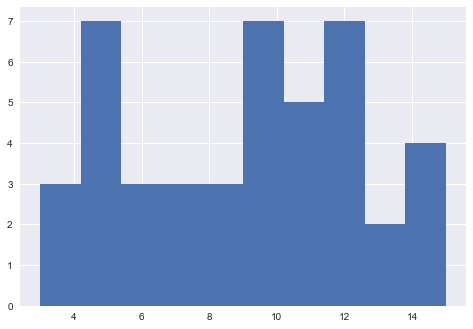

In [148]:
pd.Series(hour_attr).hist()

## Export with random customers

In [65]:
def export_graph(path, graph_id, sources):
    '''
    Sources is a vector with ids of source nodes
    '''
    new_node_map = {}
    i = 0
    for n in G.nodes(data=True):
        new_node_map[n[0]] = i
        i += 1

    with open(path + str(graph_id) + ".ntw",'w') as f:
        f.write("%d %d %d %d\n" % (graph_id, len(G), nx.number_of_edges(G), len(sources))) 
        for e in G.edges(data=True):
            f.write("%d %d %s\n" % (new_node_map[e[0]], new_node_map[e[1]], e[2]['weight']))
        for i in sources:
            f.write("%d\n" % i)
        i = 0
        for n in G.nodes(data=True):
            assert(new_node_map[n[0]] == i)
            i += 1
            f.write("%s %s\n" % (n[1]['lat'], n[1]['lon']))

In [15]:
#export with certain number of customers and readible format - create for multiple source count (many files)
# new_node_map = {}
# i = 0
# for n in G.nodes(data=True):
#     new_node_map[n[0]] = i
#     i += 1

# for sources in tqdm([2**x for x in range(7,17)]):  
#     export_graph('../data/aalborg/modified/', graph_id+1, sources)

100%|██████████| 10/10 [00:00<00:00, 24.23it/s]


In [149]:
# save potential facility locations in a separate file, one file per one city
capacity_scale = 0.6
df = pd.Series(capacity_scale*pd.Series(hour_attr),dtype=int)
df.to_csv("facility_location_hours.csv",sep=" ")
df.mean()

5.1363636363636367

## Export with population-based customers and potential facilities

In [117]:
def transform_point(point):
    lat = point[1]
    lon = point[0]
    lat0 = 55.677
    lon0 = 12.5767
    dlat = lat - lat0;
    dlon = lon - lon0;
    latitudeCircumference = 40075160. * math.cos(lat0 * math.pi/180.0);
    resX = dlon * latitudeCircumference / 360. ;
    resY = dlat * 40008000. / 360. ;
    return [resX, resY]

def transform_coords(polygon):
    new_polygon = []
    for point in polygon:
        new_polygon.append(transform_point(point))
    return new_polygon

In [118]:
# load geojson with regions
import json

from shapely.geometry import MultiPolygon, Polygon, Point

f = open("../data/cph-regions.geojson","r")
data = json.loads(f.read())


regions = {}
for j in range(len(data['features'])):
#     print transform_coords(data['features'][j]['geometry']['coordinates'][i][0])
#     break
    m = MultiPolygon([Polygon(transform_coords(data['features'][j]['geometry']['coordinates'][i][0]))
                      for i in range(len(data['features'][j]['geometry']['coordinates']))])
    regions[int(data['features'][j]['properties']['rode_nr'])] = m

regions

{1: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9cfd0>,
 2: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9c890>,
 3: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9ca10>,
 4: <shapely.geometry.multipolygon.MultiPolygon at 0x13a539590>,
 5: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9cd90>,
 6: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9ca50>,
 7: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9ca90>,
 8: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9cad0>,
 9: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9cb90>,
 10: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9c8d0>,
 11: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9c9d0>,
 12: <shapely.geometry.multipolygon.MultiPolygon at 0x13a539150>,
 13: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9c850>,
 14: <shapely.geometry.multipolygon.MultiPolygon at 0x143e9c810>,
 15: <shapely.geometry.multipolygon.MultiPolygon at 0x1475beb90>,
 16: <shapely.geome

In [68]:
# map population of the latest year to each of regions
population = pd.read_csv("../data/cph-population.csv")
population = population[population["AAR"] == population["AAR"].max()]

In [69]:
population.head()

,AAR,RODE,KOEN,ALDER,PERSONER
0,2015,1,1,0,6
1,2015,1,1,1,6
2,2015,1,1,3,3
3,2015,1,1,4,4
4,2015,1,1,5,3


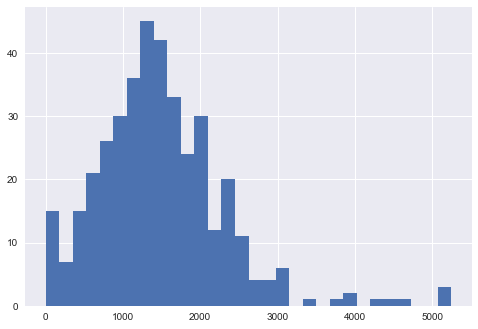

In [70]:
pop_map = population[['RODE','PERSONER']].groupby("RODE",as_index=False).sum()
pop_map['PERSONER'].hist(bins=30)

In [71]:
pop_map.head()

,RODE,PERSONER
0,1,549
1,2,698
2,3,385
3,4,295
4,5,251


In [119]:
from shapely.geometry import MultiPolygon, Polygon, Point
def get_region_id(lat, lon):
    p = Point(lat, lon)
    for k in regions:
        if (regions[k].contains(p)):
            return k
    return -1

In [150]:
# assign each graph node a corresponding distrinct (region)
node_region_id = {}
region_node_list = {}
for node in tqdm(nx.nodes_iter(G)):
    reg_id = get_region_id(float(G.node[node]["lat"]), float(G.node[node]["lon"]))
#     if (reg_id == -1):
#         print "no"
#         break
    node_region_id[node] = reg_id
    if reg_id not in region_node_list:
        region_node_list[reg_id] = []
    region_node_list[reg_id].append(node)

8813it [00:10, 611.52it/s] 

KeyboardInterrupt: 

In [121]:
pd.Series(node_region_id).value_counts()

-1      7355
 43     2708
 324    1896
 65      951
 36      855
 395     649
 63      609
 24      498
 29      422
 45      345
 72      310
 35      302
 18      284
 30      265
 59      245
 20      237
 28      236
 19      204
 62      184
 66      158
 34      132
 15      130
 79      127
 78      117
 83      115
 75      103
 64       95
 26       95
 74       90
 73       88
        ... 
 87       44
 11       36
 22       35
 69       35
 60       34
 68       33
 396      32
 76       32
 21       31
 88       30
 14       26
 106      25
 80       25
 105      20
 84       19
 77       18
 37       15
 12       15
 89       14
 81       14
 10       12
 71       10
 23        8
 56        6
 17        5
 9         3
 7         3
 13        1
 44        1
 90        1
Length: 70, dtype: int64

In [135]:
facility_fraction_in_region = {}
for region_id in regions:
    if (region_id in region_node_list) and (len(pop_map[pop_map["RODE"] == region_id]) > 0):
        facility_fraction_in_region[region_id] = \
            float(pop_map[pop_map["RODE"] == region_id]["PERSONER"]) #/ len(region_node_list[region_id])

#normalize region choice
regsum = np.sum(np.array([facility_fraction_in_region[k] for k in facility_fraction_in_region]))
facility_fraction_in_region_norm = {k: float(facility_fraction_in_region[k])/regsum 
                                    for k in facility_fraction_in_region}

probability_vector = [0]*len(G)
for region_id in regions:
    if region_id in facility_fraction_in_region:
        for node in region_node_list[region_id]:
            probability_vector[node] = facility_fraction_in_region_norm[region_id] * 1./len(region_node_list[region_id])
print np.sum(np.array(probability_vector))
# probability_vector = np.array(probability_vector)
# probability_vector = probability_vector/np.sum(probability_vector)

1.0


In [136]:
# save graph with customers
for number_of_customers in {10}:
    customer_node_ids = np.random.choice(len(probability_vector), 
                                         number_of_customers, 
                                         p=probability_vector, 
                                         replace=False)
    export_graph("./", graph_id+1, customer_node_ids)

In [137]:
number_of_customers = 150
customer_node_ids = np.random.choice(len(probability_vector), 
                                         number_of_customers, 
                                         p=probability_vector, 
                                         replace=False)

In [ ]:
# probability vector is a probability of picking from a particular region

# Plotting

In [266]:
# plot results : plot map with regions, density and random customer assignment


# plots : all city of copenhagen; road map of copenhagen (using construction hierarchies); people density; 
# facility scatter; center with facilities and customers scattered randomly;

In [11]:
import geopandas as gp
glaciers = gp.GeoDataFrame.from_file('../data/cph-regions.geojson')
f = open("../data/cph-regions.geojson","r")
data = json.loads(f.read())
for j in range(len(data['features'])):
    for i in range(len(data['features'][j]['geometry']['coordinates'])):
        data['features'][j]['geometry']['coordinates'][i][0] = transform_coords(data['features'][j]['geometry']['coordinates'][i][0])
with open("tmp.txt","w") as f:
    f.write(json.dumps(data))
glaciers = gp.GeoDataFrame.from_file("tmp.txt")
glaciers.head()

,bydel,rode_nr,areal_m2,distrikt_nr,rodenavn,id,geometry
0,Østerbro,99,,7,Bellmans,111,"(POLYGON ((-1137.63229181488 4238.00385120971,..."
1,Indre by,17,,1,Holmens,9,(POLYGON ((370.4934657375431 -28.7004139420659...
2,Valby,227,,22,Flaskekroens,255,(POLYGON ((-5412.165050265035 -3392.7878997698...
3,Indre by,2,,1,Bispegårdens,12,(POLYGON ((-655.6850471244161 173.375625876342...
4,Indre by,3,,1,Rådhusets,13,(POLYGON ((-518.3399199642896 -32.989684665054...


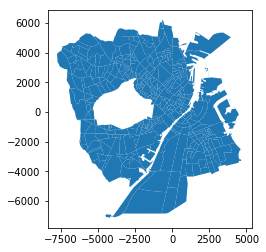

In [12]:
glaciers.plot()

In [79]:
glaciers["dens"] = glaciers["rode_nr"].apply(lambda rodeid: probability_vector[probability_index[rodeid]])
glaciers

,bydel,rode_nr,areal_m2,distrikt_nr,rodenavn,id,geometry,dens
0,Østerbro,99,,7,Bellmans,111,"(POLYGON ((-1137.63229181488 4238.00385120971,...",0.000000
1,Indre by,17,,1,Holmens,9,(POLYGON ((370.4934657375431 -28.7004139420659...,0.000000
2,Valby,227,,22,Flaskekroens,255,(POLYGON ((-5412.165050265035 -3392.7878997698...,0.000000
3,Indre by,2,,1,Bispegårdens,12,(POLYGON ((-655.6850471244161 173.375625876342...,0.000000
4,Indre by,3,,1,Rådhusets,13,(POLYGON ((-518.3399199642896 -32.989684665054...,0.000000
5,Indre by,6,,1,Synagogens,26,(POLYGON ((-325.9637067675721 657.489131958552...,0.000000
6,Indre by,7,,1,Reformert,27,(POLYGON ((-205.0026741435172 795.542333983413...,0.245911
7,Indre by,8,,1,Universitetets,28,(POLYGON ((-346.8118655158424 388.037237957343...,0.000000
8,Nørrebro,135,,8,Rantzaus,123,(POLYGON ((-1887.451730904132 1177.85402242083...,0.000000
9,Indre by,49,,1,Nyrops,16,(POLYGON ((-1348.867946082175 -369.98538898252...,0.000000


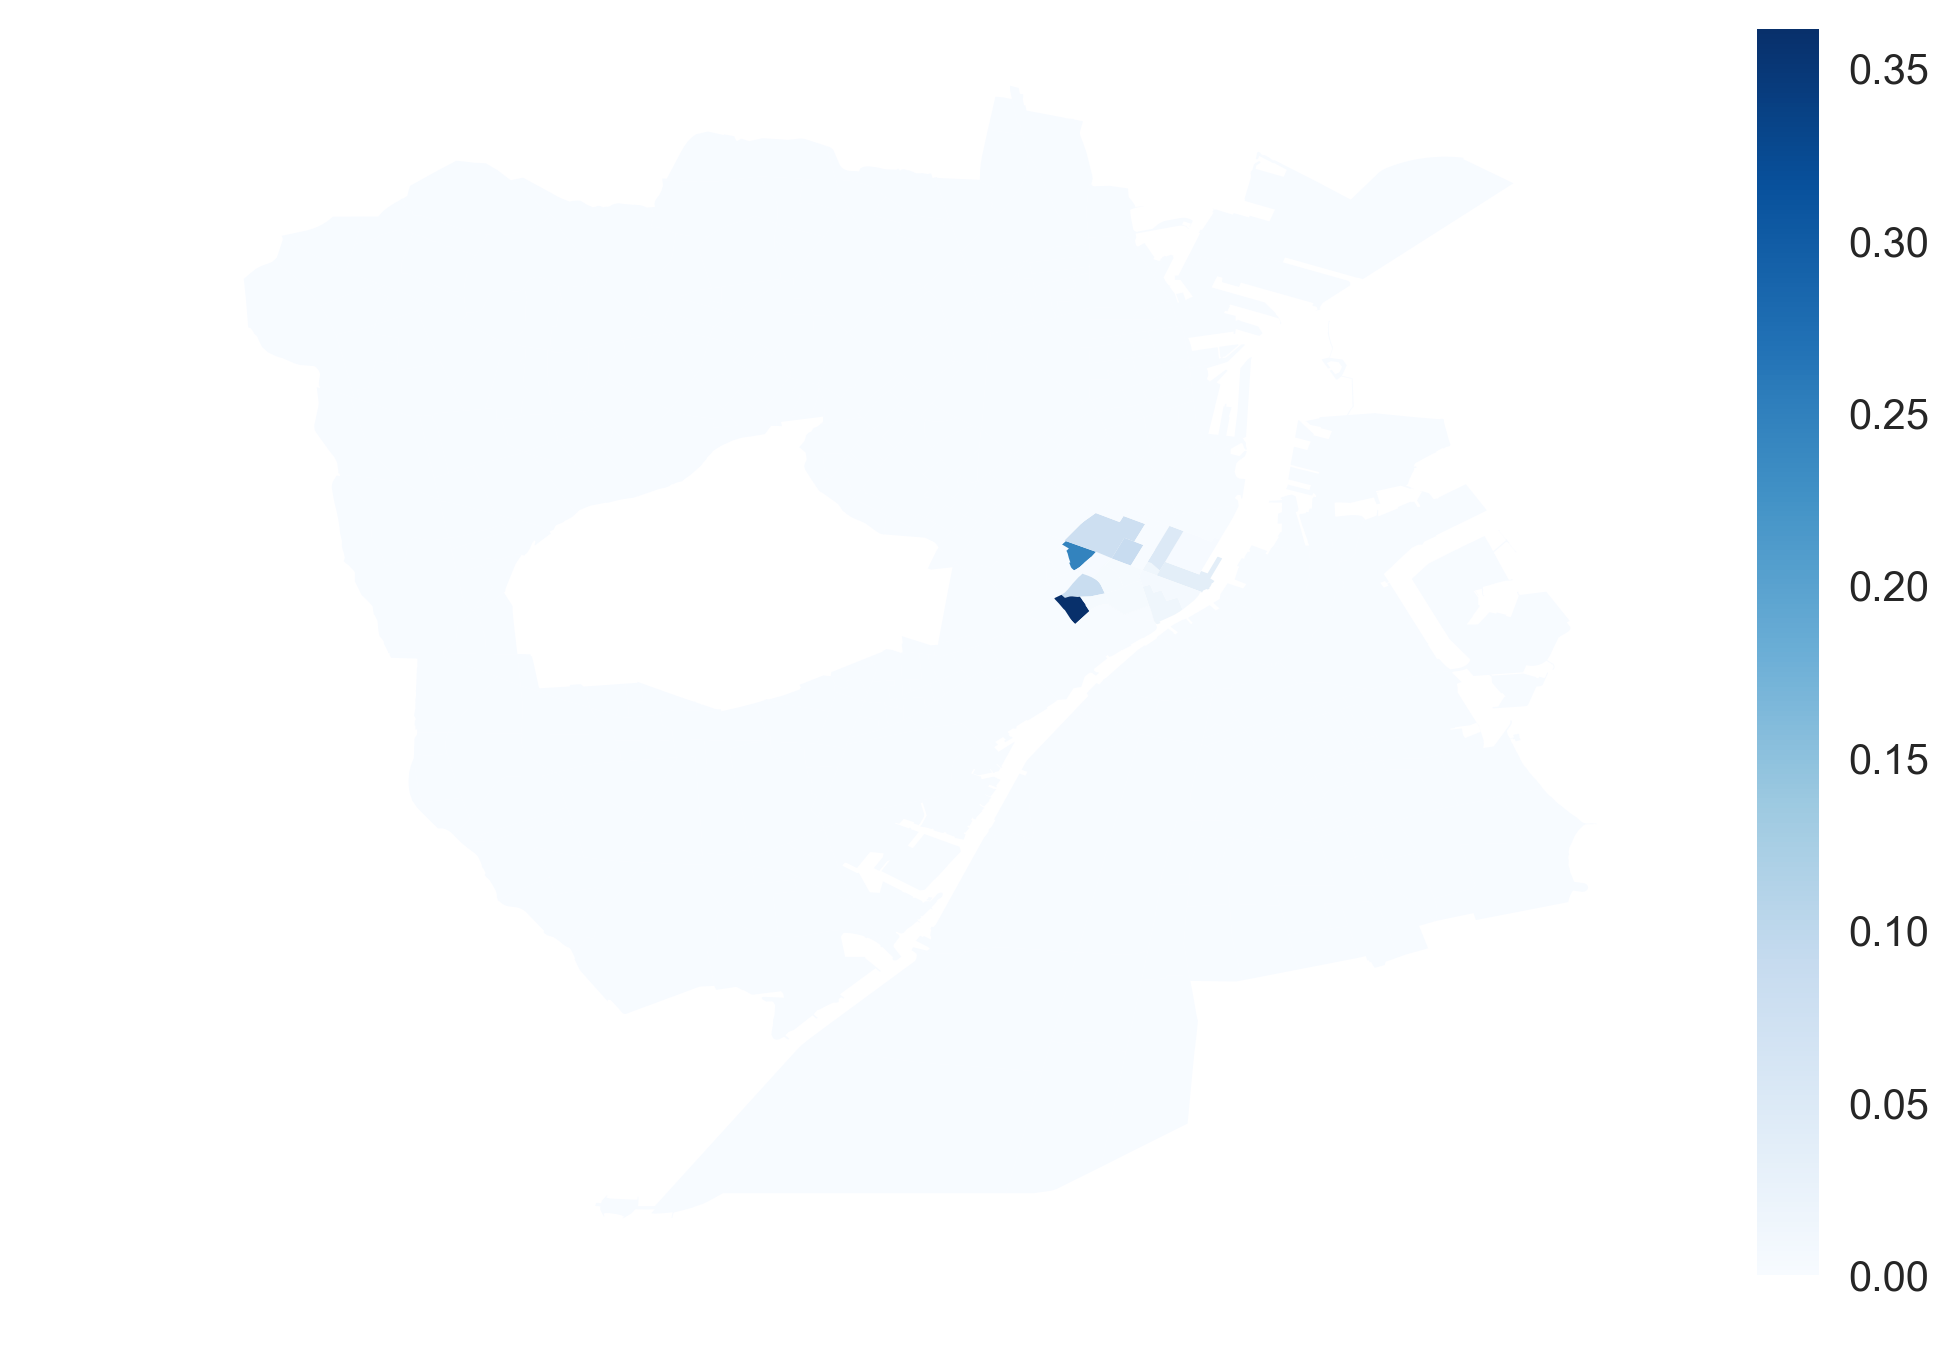

In [80]:
fig, ax1 = plt.subplots(1, dpi=300)
ax1.set_axis_off()
glaciers.plot(categorical=False,column="dens",colormap="Blues",ax=ax1, legend=True)

In [ ]:
# plot road network graph - http://geoffboeing.com/2016/11/osmnx-python-street-networks/

In [ ]:
# plot center network with assigned customers and facilities

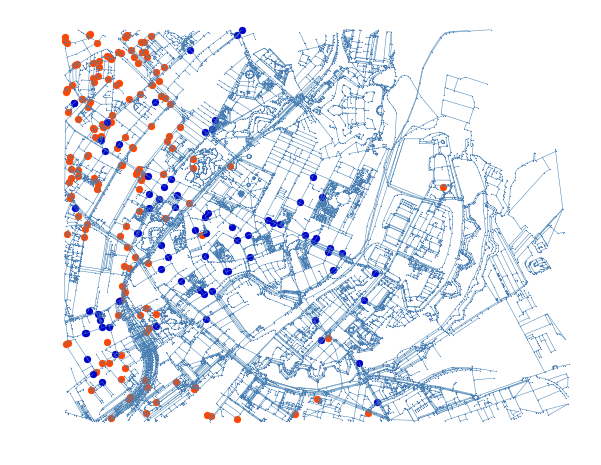

In [139]:
# print customers (shops)
# !!!!! do not run for large graphs!

import seaborn as sbn

#get customers
facility_coords = []
for key in hour_attr:
    facility_coords.append((G.node[key]['lat'], G.node[key]['lon']))

plt.figure(dpi=72,figsize=(10,8))
plt.axis('off')
        
for edge in nx.edges_iter(G):
    t = G[edge[0]][edge[1]]['etype'] 
#     plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
#              [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color=color_map[t],linewidth=0.5)
    plt.plot([G.node[edge[0]]['lat'],G.node[edge[1]]['lat']],
             [G.node[edge[0]]['lon'],G.node[edge[1]]['lon']],color="steelblue",linewidth=0.5)

tmp = []
for node in nx.nodes_iter(G):
    if len(G.node[node]) > 0:
        tmp.append([G.node[node]['lat'],G.node[node]['lon']])
tmp = np.array(tmp).T
plt.scatter(tmp[0],tmp[1],marker='.',s=3)

tmp = []
for node in customer_node_ids:
    tmp.append([G.node[node]['lat'],G.node[node]['lon']])
tmp = np.array(tmp).T
plt.scatter(tmp[0],tmp[1],marker='o',color="orangered")
    

tmp = np.array(facility_coords).T
plt.scatter(tmp[0],tmp[1],marker='o',color="mediumblue")